In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML

from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import copy

from ebov_data import *

if locations:
    pass
else:
    status()
    setFocusCountries(['SLE','LBR','GIN'])
    setColourMaps()
    loadData()

typeface='Helvetica Neue' ## set default matplotlib font and font size
#typeface='Helvetica'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

path='<iframe style="border: 0; width: 400px; height: 460px;" src="https://bandcamp.com/EmbeddedPlayer/album=1406422575/size=large/bgcol=333333/linkcol=e99708/artwork=small/track=2364395925/transparent=true/" seamless><a href="http://romowerikoito.bandcamp.com/album/und-ina">Undeina by Romowe Rikoito</a></iframe>'
totalCaseCounts={x:sum(cases_byLocation[x].values()) for x in cases_byLocation.keys()}

countryCaseCounts={}
maxByCountry={}
for country in ['SLE','GIN','LBR']:
    countryCaseCounts[country]=np.vstack([[cases_byLocation[x][y] for y in dates] for x in cases_byLocation.keys() if location_to_country[x]==country])
    countryCaseCounts[country]=np.sum(countryCaseCounts[country],axis=0)
    maxByCountry[country]=max([totalCaseCounts[z] for z in totalCaseCounts.keys() if location_to_country[z]==country])

print '\nhighest case count in district:\n%s'%('\n'.join(['%s: %s'%(x,maxByCountry[x]) for x in maxByCountry.keys()]))

print '\ncase report dates: %s'%('\t'.join(dates))
print '\nnumber of districts in case report: %s'%(len(totalCaseCounts.keys()))
print '\ndate of most recent report: %s'%(dates[-1])

print 'Done!'
HTML(path)

Operating system:       Darwin (15.6.0)
Python version:         2.7.12
Numpy version:          1.11.3
Pandas version:         0.18.1
matplotlib version:      2.0.0
scipy version:          0.18.1

This notebook was last run on:
Wednesday	2017-Mar-01	14:34	PDT

highest case count in district:
SLE: 4955
LBR: 2925
GIN: 784

case report dates: 2013-12-30	2014-01-06	2014-01-13	2014-01-20	2014-01-27	2014-02-03	2014-02-10	2014-02-17	2014-02-24	2014-03-03	2014-03-10	2014-03-17	2014-03-24	2014-03-31	2014-04-07	2014-04-14	2014-04-21	2014-04-28	2014-05-05	2014-05-12	2014-05-19	2014-05-26	2014-06-02	2014-06-09	2014-06-16	2014-06-23	2014-06-30	2014-07-07	2014-07-14	2014-07-21	2014-07-28	2014-08-04	2014-08-11	2014-08-18	2014-08-25	2014-09-01	2014-09-08	2014-09-15	2014-09-22	2014-09-29	2014-10-06	2014-10-13	2014-10-20	2014-10-27	2014-11-03	2014-11-10	2014-11-17	2014-11-24	2014-12-01	2014-12-08	2014-12-15	2014-12-22	2014-12-29	2015-01-05	2015-01-12	2015-01-19	2015-01-26	2015-02-02	2015-02-09	2015-02-16

In [3]:
#import baltic as bt ## use baltic, available at https://github.com/blab/baltic
import imp
bt = imp.load_source('baltic', '/Users/evogytis/Documents/BLAB_baltic/baltic.py')


tree_path=path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run1/Makona_1610_cds_ig.GLM.MCC.tree' 

ll=bt.loadNexus(tree_path)

for k in ll.Objects: ## MCC tree in figtree format, with actual tip names in the string
    if k.branchType=='leaf':
        k.name=k.numName

print 'Done!'


Tree height: 1.772655
Tree length: 121.249256
strictly bifurcating tree
annotations present

Numbers of objects in tree: 3219 (1609 nodes and 1610 leaves)

Done!


## Plot MCC tree with a map of West Africa

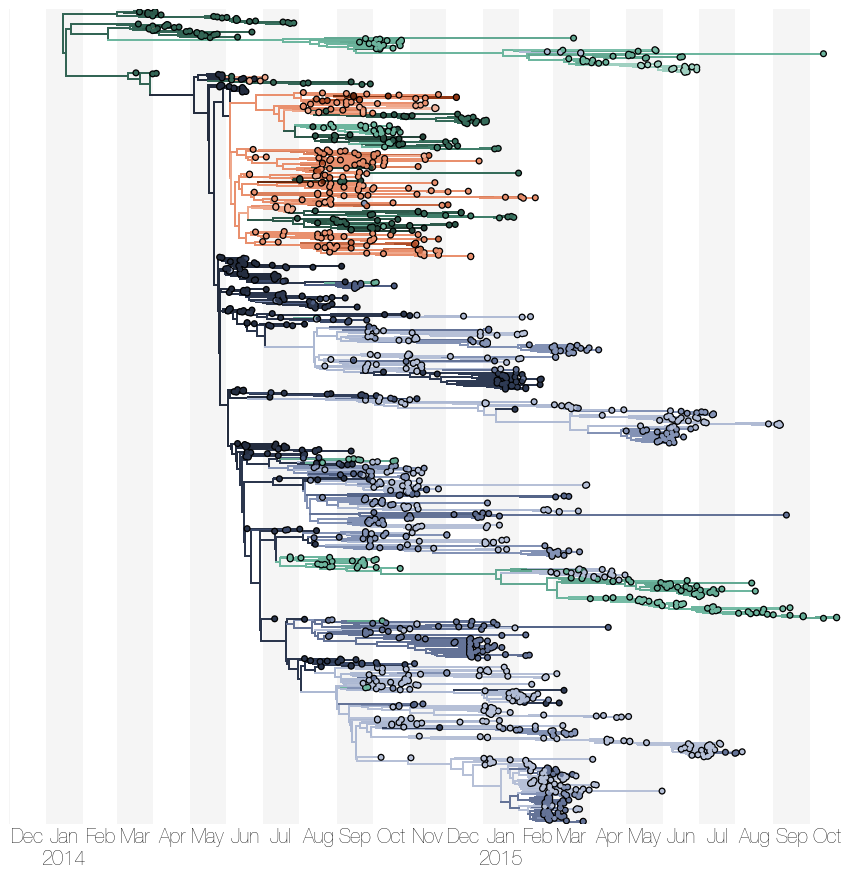

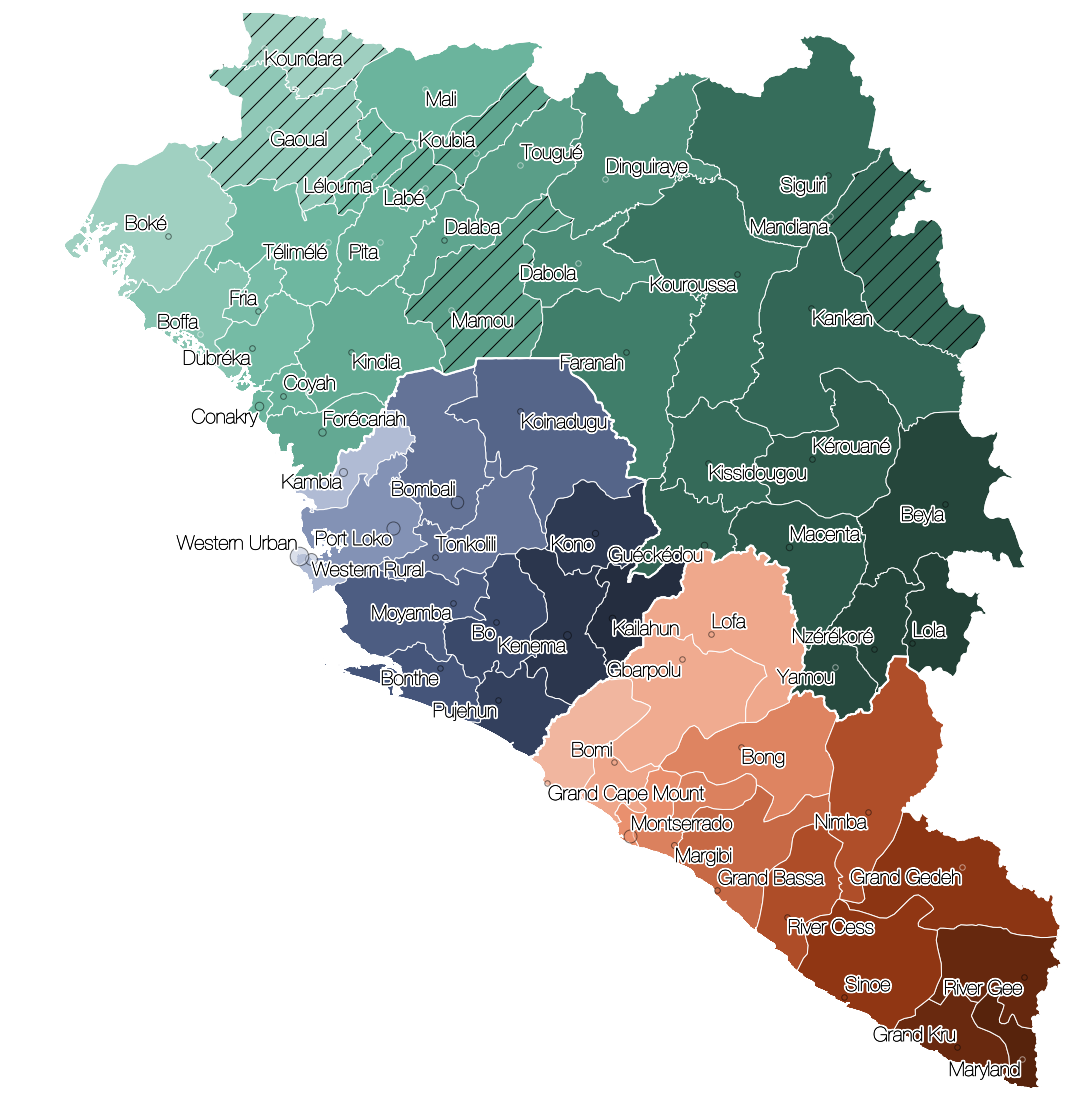

In [4]:
# fig,ax = plt.subplots(figsize=(15,320),facecolor='w') ## tree expanded vertically to allow outputing sequence labels
fig,ax = plt.subplots(figsize=(15,15),facecolor='w')

## name of districts in tree
# traitName='location'
traitName='location.states'

tipSize=20 ## tip circle radius
branchWidth=2 ## line width for branches

posteriorCutoff=0.0 ## posterior cutoff if collapsing tree

plot_tree=ll ## reference
# plot_tree=ll.collapseNodes('posterior',posteriorCutoff) ## collapse nodes lower than a given level of support

for k in plot_tree.Objects: ## iterate over branches in the tree
    location=k.traits[traitName] ## get inferred location of branch
    country=location_to_country[location] ## find country of location
    cmap=colours[country] ## fetch colour map for country
    c=cmap(normalized_coords[location]) ## get colour of location
    y=k.y ## get y coordinates
    yp=k.parent.y ## get parent's y coordinate
    
    x=k.absoluteTime ## x coordinate is absolute time
    xp=k.parent.absoluteTime ## get parent's absolute time
    
    if isinstance(k,bt.leaf): ## if tip...
        ax.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100) ## put a circle at each tip
        ax.scatter(x,y,s=tipSize+30,facecolor='k',edgecolor='none',zorder=99)
        #ax.text(x+5/365.0,y,'%s'%(k.name),size=12,zorder=101,ha='left',va='center') ## uncomment to add tip labels (only use if tree is set up with a lot of vertical space)
        
    elif isinstance(k,bt.node): ## if node...
        yl=k.children[0].y ## get y coordinates of first and last child
        yr=k.children[-1].y
        
        if xp==0.0:
            xp=x

        ls='-'
        if k.traits['posterior']<posteriorCutoff: ## change to dotted line if posterior probability too low
            ls='--'
        ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,ls=ls,zorder=98) ## plot vertical bar connecting node to both its offspring
        
    ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98) ## plot horizontal branch to parent
    
ax.xaxis.tick_bottom() ## tick bottom
ax.yaxis.tick_left() ## tick left

xDates=['2013-%02d-01'%x for x in range(11,13)] ## create a timeline centered on each month
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,12)]

[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)] ## grey vertical bar every second month
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates]) ## x ticks in the middle of each month
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates]) ## labels in mmm format unless January: then do YYYY-mmm

ax.spines['top'].set_visible(False) ## make axes invisible
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=20,size=0) ## no axis labels visible except for timeline
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])

ax.set_xlim(decimalDate('2013-12-01'),decimalDate('2015-11-01')) ## bounds on axis limits
ax.set_ylim(-4,ll.ySpan+5)

# plt.savefig(local_output+'tree.png',dpi=200,bbox_inches='tight') ## save to file
# plt.savefig(local_output+'tree.pdf',dpi=200,bbox_inches='tight')
plt.show()

# ### Plot map
fig,ax2 = plt.subplots(figsize=(20,20),facecolor='w')

for i,loc in enumerate(locations): ## iterate over locations
    country=location_to_country[loc] ## identify country
    
    if country in required_countries: ## if country is to be plotted
        countryColour=colours[country] ## get colour map
        c=countryColour(normalized_coords[loc]) ## get colour based on location

        hatch=''
        if sum(cases_byLocation[loc].values())==0: ## hatching changes if location has no cases
            hatch='/'

        ax2.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor='w',lw=1,zorder=1,hatch=hatch)) ## add location polygon collection

        lon,lat=popCentres[loc] ## get longitude/latitude of location's population centroid

        size=sum([k.length for k in ll.Objects if k.traits[traitName]==loc])**2 ## size of population centroid points depends on how long Ebola is inferred to have been in location

        ec='k'
        if size==0: ## white outline if lineages were never present
            ec='w'

        size=30+size
        ax2.scatter(lon,lat,size,facecolor=c,edgecolor=ec,lw=1,zorder=99,alpha=0.5) ## point at population centroid

        vas=['bottom','top'] ## define available text alignments and corrections for text positions
        has=['left','right']
        corrections=[0.01,-0.01]

        h=1 ## set default text alignment (right, top)
        v=1
        if textCorrection.has_key(loc): ## check if custom text positions are available
            h,v=textCorrection[loc]

        effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

        ax2.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=20,
                 va=vas[v],ha=has[h],alpha=1.0,path_effects=effects,zorder=100) ## plot district names at population centres, with corrections so as not to obscure it

for l,local_border in enumerate(global_border): ## plot the international borders
    ax2.plot(column(local_border,0),column(local_border,1),lw=2,color='w',zorder=97,label='%d_border'%(l))

ax2.set_aspect(1) ## we're close to the equator - enforce 1:1 aspect for longitude and latitude
ax2.spines['top'].set_visible(False) ## hide axes
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.tick_params(axis='x',size=0) ## no visible axis labels
ax2.tick_params(axis='y',size=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax2.set_ylim(ylimits) ## bounds on plot
ax2.set_xlim(xlimits)

# plt.savefig(local_output+'tree_legend.png',dpi=300,bbox_inches='tight') ## save to file
# plt.savefig(local_output+'tree_legend.pdf',dpi=300,bbox_inches='tight')

plt.show()

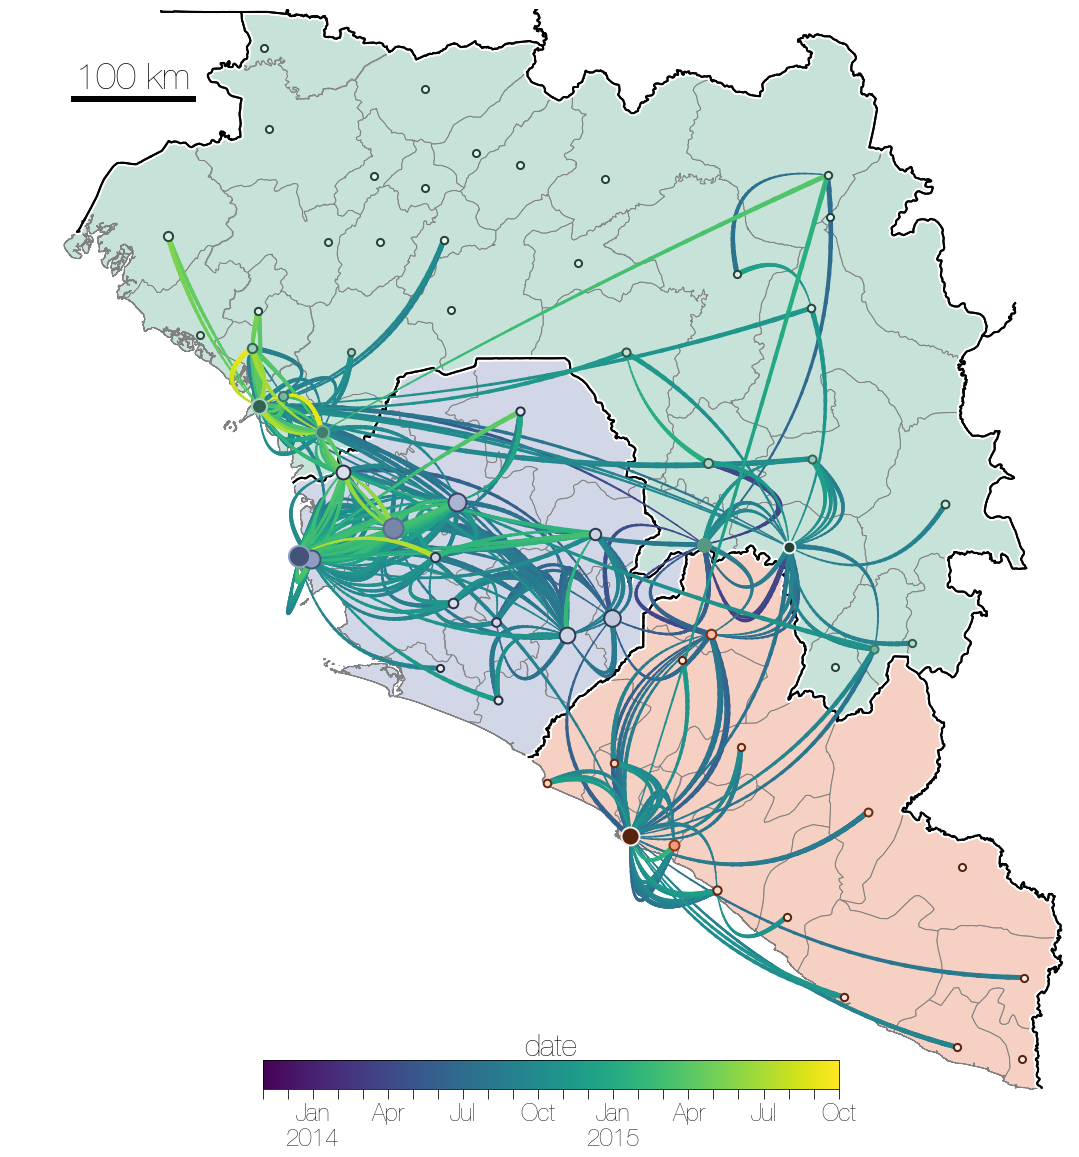

In [5]:
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

traitName='location.states' ## name of locations trait in tree

travel_lineages=sorted([k for k in ll.Objects if k.parent!=ll.root and k.traits[traitName]!=k.parent.traits[traitName]],key=lambda x:x.absoluteTime) ## only interested in lineages travelling

xDates=['2013-%02d-01'%x for x in range(11,13)] ## create timeline
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,11)]

heights=[k.absoluteTime for k in travel_lineages] ## get absolute times of each branch in the tree
height_normalization=create_normalization([decimalDate(xDates[0]),decimalDate(xDates[-1])],0.0,1.0) ## create a normalization based on timeline, where earliest day is 0.0 and latest is 1.0

cmap=mpl.cm.get_cmap('viridis') ## colour map

for k in travel_lineages: ## iterate through lineages which have switched location
    locA=k.traits[traitName] ## get location of current lineage
    locB=k.parent.traits[traitName] ## get location of where it came from
    
    oriX,oriY=popCentres[locA] ## get population centroid coordinates
    desX,desY=popCentres[locB]
    
    normalized_height=height_normalization(k.absoluteTime) ## normalize heights of lineages
    normalized_parent_height=height_normalization(k.parent.absoluteTime)
    
    distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2)) ## find travelling distance
    
    adjust_d=1-2*normalized_height+1/float(distance)**0.1-0.5 ## position Bezier curve control point according to an arbitrary function
    
    n=Bezier_control((oriX,oriY),(desX,desY),adjust_d) ## control point perpendicular to midway between point A and B at a distance adjust_d
    
    curve=Bezier([(oriX,oriY),n,(desX,desY)],0.0,1.0,num=30) ## get Bezier line coordinates
    
    for i in range(len(curve)-1): ## iterate through Bezier curve coordinates, alter colour according to height
        x1,y1=curve[i]
        x2,y2=curve[i+1]
        frac=i/float(len(curve)) ## fraction along line
        
        ax.plot([x1,x2],[y1,y2],lw=1+4*(1-frac),color=cmap(normalized_parent_height+(normalized_height-normalized_parent_height)*(1-frac)),zorder=int(normalized_height*10000)) ## curve tapers and changes colour

for i,loc in enumerate(locations): ## iterate over locations
    country=location_to_country[loc] ## get country
    
    if country in required_countries: ## if country required
        countryColour=colours[country] ## get colour map
        c=countryColour(totalCaseCounts[loc]/float(maxByCountry[country])) ## colour proportional to cases

        ax.add_collection(PatchCollection(polygons[loc],facecolor=countryColour(0.1),edgecolor='grey',lw=1,zorder=1)) ## polygon colour pale

        lon,lat=popCentres[loc] ## population centroid coordinates

        size=[k.traits[traitName] for k in ll.Objects].count(loc) ## circle size proportional to branches in location
        size=50+size
        ax.scatter(lon,lat,size,facecolor=c,edgecolor=desaturate(countryColour(1-(totalCaseCounts[loc]/float(maxByCountry[country]))),1.0),lw=2,zorder=200000) ## plot circle, edge coloured inversely from main colour

ycoord=np.mean([4.3,12.7]) ## add bar to indicate distance
legend_y=12.0
legend_x1=-15
legend_x2=-14.08059

ax.plot([legend_x1,legend_x2],[legend_y,legend_y],color='k',lw=6)
ax.text(np.mean([legend_x1,legend_x2]),legend_y+0.04,'%.0f km'%metricDistance((legend_x1,legend_y),(legend_x2,legend_y)),size=36,va='bottom',ha='center')

colorbarTextSize=30 ## add colourbars
colorbarTickLabelSize=24
colorbarWidth=0.02
colorbarHeight=0.4
colorbarIncrement=0.08

ax2 = fig.add_axes([colorbarIncrement*4, 0.13, colorbarHeight, colorbarWidth]) ## add dummy axes

mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=mpl.colors.Normalize([decimalDate(xDates[0]),decimalDate(xDates[-1])]),orientation='horizontal')
ax2.xaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=len(xDates))) ## add colour bar to axes

xaxis_labels=['' if (int(x.split('-')[1])+2)%3!=0 else convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates] ## month if month+2 is divisible by 3 (January, April, July, October)
    
ax2.set_xticklabels(xaxis_labels) ## set colour bar tick labels
ax2.xaxis.set_label_position('top') ## colour bar label at the top
ax2.set_xlabel('date',color='k',size=colorbarTextSize) ## colour bar label is "date"
ax2.tick_params(labelcolor='k',size=10,labelsize=colorbarTickLabelSize) ## adjust axis parameters

for l,local_border in enumerate(global_border): ## plot the international borders
    ax.plot(column(local_border,0),column(local_border,1),lw=2,color='k',zorder=97)
    ax.plot(column(local_border,0),column(local_border,1),lw=6,color='w',zorder=96)

ax.set_aspect(1) ## aspect of 1 because we're close to the equator
ax.spines['top'].set_visible(False) ## invisible axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(size=0) ## invisible axis labels
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(ylimits) ## bounds on plot
ax.set_xlim(xlimits)

# plt.savefig(local_output+'geoTree.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'geoTree.pdf',dpi=300,bbox_inches='tight')
plt.show()

Number of cells to plot: 9
0 0 ['2013-12-30', '2014-01-06', '2014-01-13', '2014-01-20', '2014-01-27', '2014-02-03', '2014-02-10', '2014-02-17', '2014-02-24', '2014-03-03']
1 10 ['2014-03-10', '2014-03-17', '2014-03-24', '2014-03-31', '2014-04-07', '2014-04-14', '2014-04-21', '2014-04-28', '2014-05-05', '2014-05-12']
2 20 ['2014-05-19', '2014-05-26', '2014-06-02', '2014-06-09', '2014-06-16', '2014-06-23', '2014-06-30', '2014-07-07', '2014-07-14', '2014-07-21']
3 30 ['2014-07-28', '2014-08-04', '2014-08-11', '2014-08-18', '2014-08-25', '2014-09-01', '2014-09-08', '2014-09-15', '2014-09-22', '2014-09-29']
4 40 ['2014-10-06', '2014-10-13', '2014-10-20', '2014-10-27', '2014-11-03', '2014-11-10', '2014-11-17', '2014-11-24', '2014-12-01', '2014-12-08']
5 50 ['2014-12-15', '2014-12-22', '2014-12-29', '2015-01-05', '2015-01-12', '2015-01-19', '2015-01-26', '2015-02-02', '2015-02-09', '2015-02-16']
6 60 ['2015-02-23', '2015-03-02', '2015-03-09', '2015-03-16', '2015-03-23', '2015-03-30', '2015-04

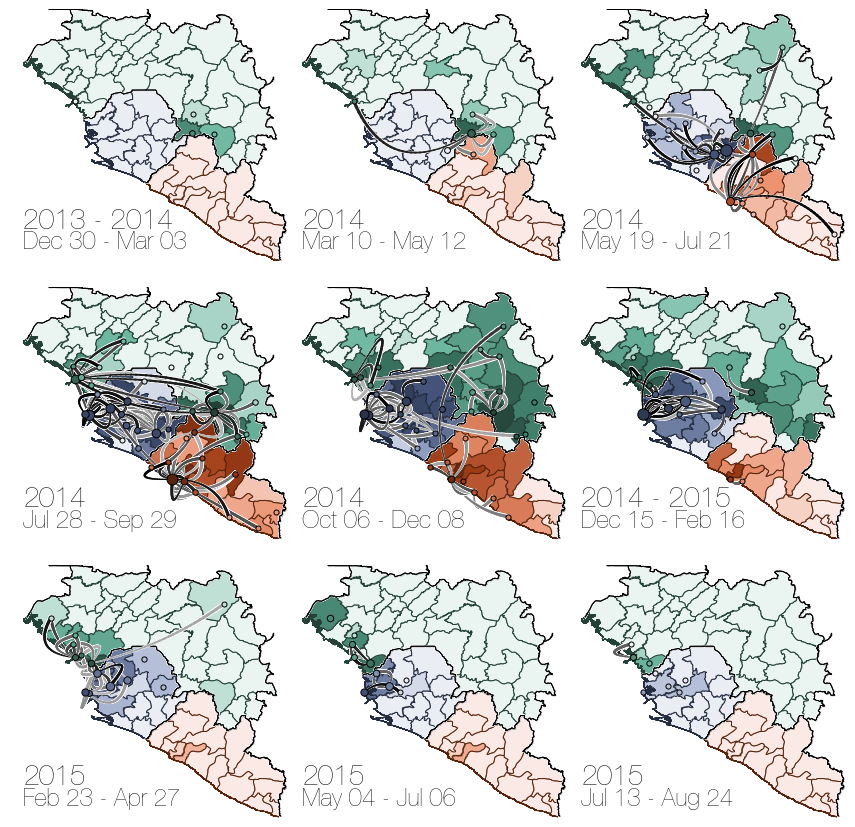

In [6]:
normCmap=make_cmap([mpl.cm.Greys(x) for x in np.linspace(0.4,1.0,256)])

traitName='location.states'
travel_lineages=sorted([k for k in ll.Objects if k.parent!=ll.root and k.traits[traitName]!=k.parent.traits[traitName]],key=lambda x:x.absoluteTime)

partitioning=10 ## choose how many epi weeks to lump together
dates2=dates[:dates.index('2015-08-31')] ## only plot up to end of August

dateRange=range(0,len(dates2),partitioning) ## indices for lumping epiweeks

lumpy_maxima={country:0 for country in required_countries} ## will contain maximum number of cases in any given epiweek lump, split by country
for country in required_countries: ## iterate over countries
    for d,idx in enumerate(dateRange): ## iterate over lumps of epiweeks
        epiweeks=dates2[idx:idx+partitioning] ## fetch epiweeks
        
        for loc in cases_byLocation.keys(): ## iterate over locations
            c=location_to_country[loc] ## find country
            if c==country: ## if country matches
                case_lump=sum([cases_byLocation[loc][week] for week in epiweeks]) ## lump cases across epiweeks
                if case_lump>=lumpy_maxima[country]: ## if current location has more cases across epiweeks it becomes new maximum
                    lumpy_maxima[country]=case_lump
    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cols=3 ## number of columns
N=len(dateRange) ## number of individual maps
rows=int(N/cols)+1 ## find the number of rows required to plot all lumps

print 'Number of cells to plot: %d'%(N)

scale=5 ## fig size scalar
plt.figure(figsize=(cols*scale,rows*scale),facecolor='w')

gs = gridspec.GridSpec(rows, cols,hspace=0.1,wspace=0.0,width_ratios=[1 for c in range(cols)],height_ratios=[1 for r in range(rows)]) ## gridspec for figure grid

epiweek_stepsize=decimalDate(dates2[1])-decimalDate(dates2[0]) ## find how long an epiweek is, should be around 7/365.0

timemin='2013-12-01' ## start time
timemax='2015-11-01' ## end time

height_normalization=create_normalization([decimalDate(timemin),decimalDate(timemax)],0.0,1.0) ## create height normalization where 0.0 is earliest and 1.0 is latest

for d,idx in enumerate(dateRange): ## iterate over epiweek lumps
    epiweeks=dates2[idx:idx+partitioning] ## fetch epiweeks in lump
    
    first=epiweeks[0]
    last=epiweeks[-1]
    
    treeStart=decimalDate(epiweeks[0]) ## tree starts at the beginning of the first epiweek in lump
    treeEnd=decimalDate(epiweeks[-1])+epiweek_stepsize ## finishes at the end of the last epiweek
    
    print d,idx,epiweeks
    
    cases_in_lump={loc:sum([cases_byLocation[loc][week] for week in epiweeks]) for loc in cases_byLocation.keys()} ## identify how many cases are in lump
    
    row=int(d/cols) ## current row is *quotient* when dividing lump index by number of available columns
    
    if row==0: ## current column is *remainder* when dividing lump index by number of available columns
        col=d
    else:
        col=d%cols

    height_normalization=create_normalization([treeStart,treeEnd],0.0,1.0) ## normalize heights to be within [0.0,1.0]
    
    ax = plt.subplot(gs[row, col]) ## fetch axes at the right cell in the grid
    
    for k in travel_lineages: ## iterate over travelling lineages
        if treeStart<np.mean([k.parent.absoluteTime,k.absoluteTime])<=treeEnd: ## if travelling lineage's mid-point is within interval - plot it
            locA=k.traits[traitName] ## end location
            locB=k.parent.traits[traitName] ## start location

            oriX,oriY=popCentres[locA]
            desX,desY=popCentres[locB]

            normalized_height=height_normalization(k.absoluteTime) ## normalize time of lineage
            normalized_parent_height=height_normalization(k.parent.absoluteTime)

            distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))
            adjust_d=1-2*normalized_height+1/float(distance)**0.1-0.5
            n=Bezier_control((oriX,oriY),(desX,desY),adjust_d)
            curve=Bezier([(oriX,oriY),n,(desX,desY)],0.0,1.0,num=30)

            midpoint=np.mean([normalized_parent_height,normalized_height])
            
            for i in range(len(curve)-1): ## iterate through Bezier curve coordinates, alter colour according to height
                x1,y1=curve[i]
                x2,y2=curve[i+1]
                frac=1-(i/float(len(curve)))

                ax.plot([x1,x2],[y1,y2],lw=1+2*frac,color=normCmap(midpoint),zorder=int(normalized_height*10000))
                ax.plot([x1,x2],[y1,y2],lw=1+4*frac,color='w',zorder=int(normalized_height*10000)-1)
            
    for i,loc in enumerate(locations):
        country=location_to_country[loc]
        
        if country in required_countries:
            countryColour=colours[country]
            c=countryColour(np.log10(cases_in_lump[loc])/float(np.log10(lumpy_maxima[country])))

            ax.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor=countryColour(1.0),lw=1,zorder=1))

            lon,lat=popCentres[loc]

            size=[k.traits[traitName] for k in ll.Objects if k.parent.absoluteTime<=treeEnd and treeStart<=k.absoluteTime].count(loc)/2.0

            if size>0:
                size+=25
            ax.scatter(lon,lat,size,facecolor=c,edgecolor='k',lw=1,zorder=200000)
        
    ax.text(0.05,0.13,'%s'%(' - '.join(unique([first.split('-')[0],last.split('-')[0]]))),size=28,transform=ax.transAxes)
    ax.text(0.05,0.05,'%s - %s'%(convertDate(first,'%Y-%m-%d','%b %d'),convertDate(last,'%Y-%m-%d','%b %d')),size=24,transform=ax.transAxes)

    for l,local_border in enumerate(global_border):
        ax.plot(column(local_border,0),column(local_border,1),lw=1,color='k',zorder=97,label='%d_border'%(l))
        ax.plot(column(local_border,0),column(local_border,1),lw=2,color='w',zorder=96)
        
    colorbarTextSize=30
    colorbarTickLabelSize=20
    colorbarWidth=0.02
    colorbarHeight=0.35

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_ylim(ylimits)
    ax.set_xlim(xlimits)

# plt.savefig(local_output+'spatial.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'spatial.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [7]:
branchWidth=2
tipSize=30

traitName='location.states'
# traitName='location'
ll.root.traits[traitName]='reservoir' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch
ll.root.y=0
ll.root.x=ll.Objects[0].absoluteTime

location_to_country['reservoir']='?'
normalized_coords['reservoir']=1.0

tree_strings={'SLE':[],'GIN':[],'LBR':[]} ## will contain tree string derived from introductions into each country
country_trees={'SLE':[],'GIN':[],'LBR':[]}
loc_trees={}

subtree_sizes={loc:[] for loc in locations}
subtree_sizes['WesternArea']=[]
subtree_lengths={loc:[] for loc in locations}
subtree_lengths['WesternArea']=[]

output_subtrees=open(local_output+'subtrees.txt','w')
print>>output_subtrees,'location\tcountry\torigin location\torigin country\tclade TMRCA\tparent TMRCA\tclade size\tpersistence\ttree string'

output_members=open(local_output+'members.txt','w')

for l in sorted(ll.Objects,key=lambda x:x.height): ## iterate over branches
    k=l
    kp=l.parent
    
    kloc=k.traits[traitName]
    if k.parent.traits.has_key(traitName): ## get current branch's country and its parent's country
        kploc=kp.traits[traitName]
        kpc=location_to_country[kploc]
    else: ## if parent doesn't have a trait - dealing with root of tree
        kploc='reservoir'
        kpc='reservoir'

    kc=location_to_country[kloc]
    
    if kloc!=kploc: ## if locations don't match
        if isinstance(k,bt.node): ## and dealing with node
            N_children=len(k.leaves)
        else: ## dealing with leaf...
            N_children=1
        
        loc_subtree=ll.subtree(k,traitName=traitName) ## extract subtree during a within-trait traversal
        if loc_subtree: ## successful extraction (not None)
            loc_leaves=[x.name for x in loc_subtree.Objects if isinstance(x,bt.leaf)] ## get leaves in resulting subtree

            print 'location: %s to %s jump (ancestor %d, %d leaves in full tree, now has %d)'%(kploc,kloc,k.index,N_children,len(loc_leaves))
            if loc_trees.has_key(kloc):
                loc_trees[kloc].append((kploc,loc_subtree))
            else:
                loc_trees[kloc]=[(kploc,loc_subtree)]
            
            subtree_sizes[kloc].append(len(loc_leaves)) ## remember subtree size
    
    if kc!=kpc: ## if countries don't match
        subtree=ll.subtree(k,traitName=traitName,converterDict=location_to_country)
        
        if subtree: ## if subtree extracted
            if isinstance(k,bt.leaf): ## if dealing with a leaf that switched
                N_children=1
            else:
                N_children=len(k.leaves)
                
            subtree_leaves=[x.numName for x in subtree.Objects if isinstance(x,bt.leaf)]
            print 'country: %s (%s) to %s (%s) jump (ancestor %d, %d leaves in full tree, now has %d)'%(kpc,kploc,kc,kloc,k.index,N_children,len(subtree_leaves))
            
            subtree_lengths[kloc].append((k.length*0.5)+max([decimalDate(x.strip("'").split('|')[-1]) for x in subtree_leaves])-k.absoluteTime) ## remember time from mid-point of branch to last tip (subtree height)
            
            subtree.singleType() ## convert to single type tree in case multitype tree was returned
            tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
            country_trees[kc].append((kploc,subtree))

            mostRecentSubtreeTip=max([decimalDate(x.strip("'").split('|')[-1]) for x in subtree_leaves])
            persistence=mostRecentSubtreeTip-k.absoluteTime
            ancestorTime=k.parent.absoluteTime
            cladeTMRCA=k.absoluteTime
            originCountry=kpc
            originLoc=kploc
            cladeSize=len(subtree_leaves)

            subtreeString=subtree.toString()

            print>>output_subtrees,'%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s'%(kc,kloc,kpc,kploc,cladeTMRCA,ancestorTime,len(subtree_leaves),persistence,subtreeString)

            print>>output_members,'%s'%(','.join(subtree_leaves))


output_subtrees.close()
output_members.close()
print 'Done!'

location: reservoir to Gueckedou jump (ancestor 0, 1610 leaves in full tree, now has 45)
country: ? (reservoir) to GIN (Gueckedou) jump (ancestor 0, 1610 leaves in full tree, now has 118)
location: Gueckedou to Macenta jump (ancestor 7405935, 5 leaves in full tree, now has 5)
location: Gueckedou to Kissidougou jump (ancestor 3, 1 leaves in full tree, now has 1)
location: Gueckedou to Lofa jump (ancestor 6895657, 1 leaves in full tree, now has 1)
country: GIN (Gueckedou) to LBR (Lofa) jump (ancestor 6895657, 1 leaves in full tree, now has 1)
location: Gueckedou to Kissidougou jump (ancestor 6901015, 1 leaves in full tree, now has 1)
location: Gueckedou to Macenta jump (ancestor 6964371, 1 leaves in full tree, now has 1)
location: Gueckedou to Kailahun jump (ancestor 5244, 1485 leaves in full tree, now has 105)
country: GIN (Gueckedou) to SLE (Kailahun) jump (ancestor 5244, 1485 leaves in full tree, now has 1010)
location: Kailahun to Gueckedou jump (ancestor 6830844, 10 leaves in full t

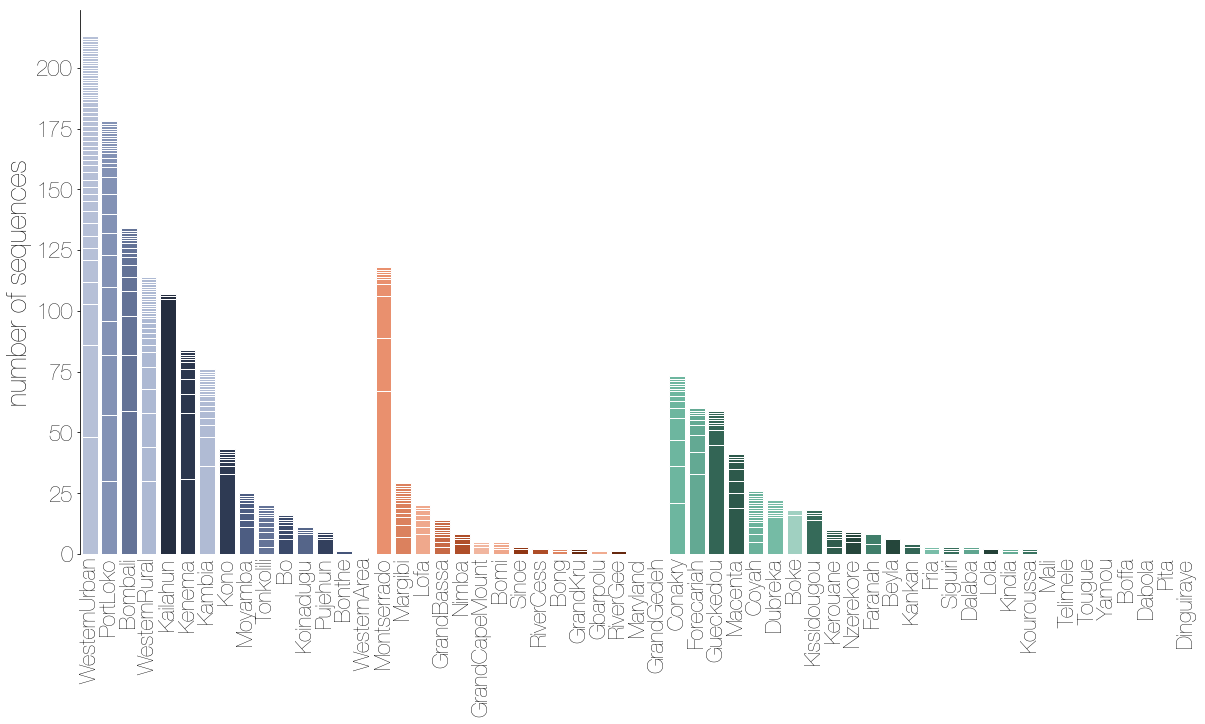

In [8]:
fig,ax = plt.subplots(figsize=(20,10),facecolor='w')

xs=sorted(subtree_sizes.keys(),key=lambda x:(location_to_country[x],np.log10(sum(subtree_sizes[x]))),reverse=True) ## sort by country, then by number of introductions
# xs=sorted(subtree_sizes.keys(),key=lambda x:(location_to_country[x],-sum(subtree_sizes[x])))

xs=[x for x in xs if sum(cases_byLocation[x].values())>0]

for l,loc in enumerate(xs):
    country=location_to_country[loc]
    c=colours[country](normalized_coords[loc])

    ys=sorted(subtree_sizes[loc],reverse=True)
    for y,val in enumerate(ys):
        ax.bar(l,val,bottom=sum(ys[:y]),facecolor=c,edgecolor='w',lw=1,align='center') ## plot stacked bars of introduction sizes for each location
        
ax.set_xticks(range(len(xs)))
ax.set_xticklabels(xs,rotation=90)

ax.set_xlim(-0.5,len(xs)-0.5)
ax.set_ylabel('number of sequences',size=28)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.yaxis.tick_left()

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',direction='out')
plt.show()

In [9]:
persistence_out=open(local_output+'EBOV_1610_loc_persistence.txt','w')
print>>persistence_out,'location\tclade sizes\tN introductions\tmedian persistence (days)\tmean persistence (days)\tstandard deviation\tpersistences (years)'
for loc in subtree_lengths.keys():
    L=len(subtree_lengths[loc])
    
    cS=map(str,subtree_sizes[loc])
    med=np.median(subtree_lengths[loc])*365
    mu=np.mean(subtree_lengths[loc])*365
    std=np.std(subtree_lengths[loc])
    
    if L>0:
        print loc,cS,L,med,mu,std
    print>>persistence_out,'%s\t%s\t%d\t%s\t%s\t%s\t%s'%(loc,','.join(cS),L,med,mu,std,','.join(map(str,subtree_lengths[loc])))
#     if len(subtree_lengths[loc])>0:
#         fig,ax = plt.subplots(figsize=(5,5),facecolor='w')
#         ax.hist([365*x for x in subtree_lengths[loc]],facecolor='steelblue')
#         ax.set_xlim(0,365)
#         plt.show()
persistence_out.close()

Macenta ['5', '1', '19', '6', '3', '1', '5', '1'] 4 168.6175775 162.213179375 0.0539552602901
Gueckedou ['45', '6', '1', '1', '1', '1', '1', '1', '2'] 4 66.41673875 193.53007 0.712882845017
Forecariah ['4', '1', '2', '33', '1', '1', '9', '2', '7'] 3 64.4750124999 53.4919758333 0.0780823754825
Lofa ['1', '3', '8', '1', '3', '2', '2'] 3 17.9549174999 13.0052483333 0.0200792012825
Nzerekore ['5', '1', '2', '1'] 2 40.5468675 40.5468675 0.0427407328767
Kambia ['1', '2', '2', '1', '1', '2', '36', '1', '3', '3', '12', '1', '1', '1', '5', '1', '1', '1', '1'] 6 27.13901125 35.2960229167 0.073074014138
PortLoko ['1', '14', '27', '1', '7', '1', '9', '4', '1', '1', '1', '1', '1', '1', '25', '2', '14', '13', '8', '2', '1', '1', '2', '1', '30', '8', '1'] 1 19.5576925 19.5576925 0.0
Kailahun ['105', '1', '1'] 1 514.1444775 514.1444775 0.0
Montserrado ['17', '67', '22', '1', '1', '5', '1', '2', '1', '1'] 1 255.105085 255.105085 0.0
Siguiri ['1', '1', '1'] 1 68.2974775 68.2974775 0.0
Conakry ['21', '4'

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


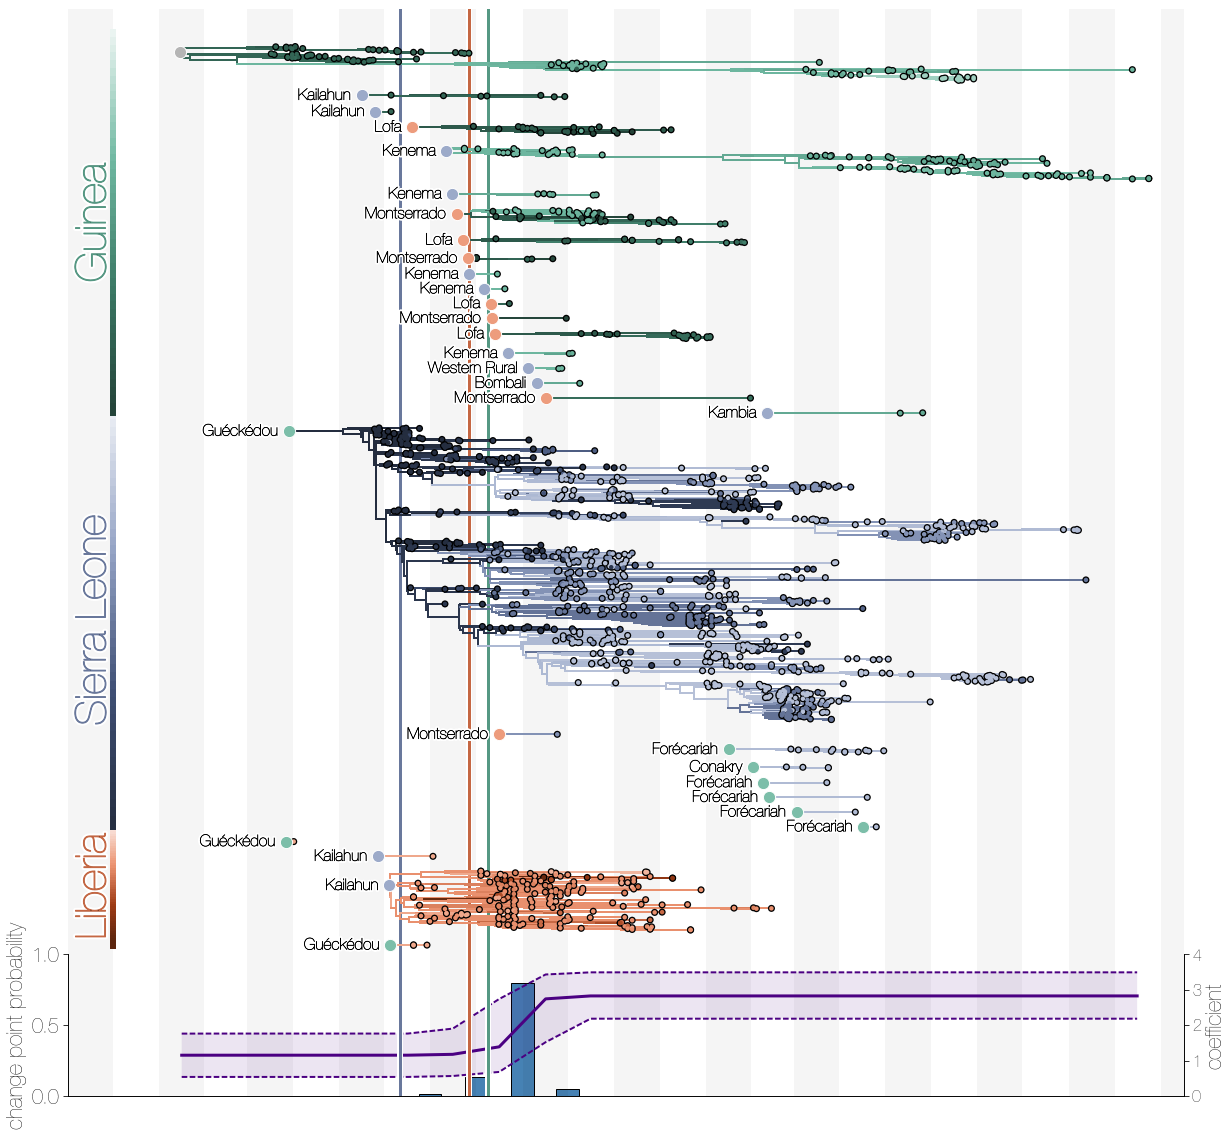

In [10]:
fig = plt.figure(figsize=(20,20),facecolor='w') ## set up whole figure
gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.15],wspace=0.00,hspace=0.00) ## set up grid

# fig = plt.figure(figsize=(20,100),facecolor='w') ## for locations
# gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.05],wspace=0.00,hspace=0.00) ## for locations

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],sharex=ax)

# traitName='location'
traitName='location.states'
branchWidth=2
tipSize=20

closure_dates={'SLE':'2014-06-11','GIN':'2014-08-09','LBR':'2014-07-27'} ## border closure dates
country_order={'GIN':3,'SLE':2,'LBR':1} ## order of countries

map_to_actual['WesternArea']='Western Area'

effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

cumulative_y=0
for tree_country in sorted(country_trees.keys(),key=lambda x:country_order[x]): ## iterate over countries
    for t,tr in enumerate(sorted(country_trees[tree_country],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over subtrees within the country in order of introduction
        origin,loc_tree=tr
        
        if len([ob for ob in loc_tree.Objects if ob.branchType=='leaf'])>0: ## if there's at least one leaf in subtree
            for w in loc_tree.Objects: ## iterate over subtree branches
                location=w.traits[traitName] ## get location
                country=location_to_country[location] ## get country from location
                cmap=colours[country] ## get colour map for country
                c=cmap(normalized_coords[location]) ## get standardised colour for location

                y=w.y
                x=w.absoluteTime
                
                if y!=None:
                    if w.parent!=None:
                        xp=w.parent.absoluteTime
                        yp=w.parent.y
                    else:
                        xp=x
                        yp=y
                    
                    if isinstance(w,bt.leaf): ## leaves have circles at tips
                        ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=c,edgecolor='none',zorder=100) ## plot tip circle
                        ax.scatter(x,y+cumulative_y,s=tipSize+30,facecolor='k',edgecolor='none',zorder=99)

                    elif isinstance(w,bt.node): ## nodes have vertical lines
                        yl=w.children[0].y
                        yr=w.children[-1].y

                        ax.plot([x,x],[yl+cumulative_y,yr+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot vertical bar
                    
                    ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot branch

            oriC=colours[location_to_country[origin]](0.3)
            if loc_tree.Objects[0].absoluteTime==None:
                oriX=loc_tree.Objects[0].absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y
            else:
                oriX=loc_tree.Objects[0].parent.absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y

            if origin!='reservoir': ## add text if not dealing with first intro
                ax.text(oriX-7/365.0,oriY,'%s'%(map_to_actual[origin]),ha='right',va='center',
                        size=16,path_effects=effects) ## uncomment to plot text at the beginning of the subtree to indicate its origin, only use with enough vertical space
                
#                 ax.text(oriX-7/365.0,oriY,'%s'%(map_to_actual[origin]),ha='right',va='center',
#                         size=16) ## uncomment to plot text at the beginning of the subtree to indicate its origin, only use with enough vertical space
                
            ax.scatter(oriX,oriY,150,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## circle at the base of the subtree to indicate origin
            
            ## track when switching countries
            if t==0:
                rememberCumulative_y=cumulative_y
            
            cumulative_y+=max([x.y for x in loc_tree.Objects])+50 ## increment y position
            
            if t==len(country_trees[tree_country])-1:
                c=colours[tree_country](0.5)
                label_effects=[path_effects.Stroke(linewidth=5, foreground='w'),
                 path_effects.Stroke(linewidth=1.0, foreground=c)] ## country colour text, white outline
                
                rs=np.linspace(cumulative_y,rememberCumulative_y,50) ## country span line
                for r in range(len(rs)-1):
                    ax.plot([decimalDate('2013-12-01')]*2,[rs[r],rs[r+1]],lw=6,color=colours[country](r/float(len(rs)-1)),zorder=9) ## plot segment with fading colour
                ax.text(decimalDate('2013-12-01'),
                        (cumulative_y+rememberCumulative_y)/2.0,'%s'%(translate[tree_country]),
                        size=42,rotation=90,ha='right',va='center',
                        path_effects=label_effects,zorder=10) ## name of country
                
#                 ax.text(decimalDate('2013-12-01'),
#                         (cumulative_y+rememberCumulative_y)/2.0,'%s'%(translate[tree_country]),
#                         size=42,rotation=90,ha='right',va='center',zorder=10) ## name of country
                

####################    
epoch_path=path_to_dropbox+'Sequences/Jun2016_1610_genomes/GLM/epoch/changePointEstimates.csv'

xs=[]
ymu=[]
yhi=[]
ylo=[]
ps=[]

axx=ax2.twinx() ## secondary y axis

for line in open(epoch_path,'r'): ## load epoch data
    l=line.strip('\n').split(',') 
    if l[0]=='month':
        header=l
    else:
        d=decimalDate(l[0],fmt='%b-%y')
        prob,meanC,hpLo,hpHi=map(float,l[1:])
        xs.append(d)
        ps.append(prob)
        ymu.append(meanC)
        yhi.append(hpHi)
        ylo.append(hpLo)
        
ax2.bar(xs,ps,width=1/24.0,align='center',facecolor='steelblue',lw=1,edgecolor='k')
axx.plot([x+1/24.0 for x in xs],ymu,color='indigo',lw=3)
axx.fill_between([x+1/24.0 for x in xs],ylo,yhi,facecolor='indigo',edgecolor='none',alpha=0.1)
axx.plot([x+1/24.0 for x in xs],ylo,color='indigo',ls='--',alpha=1.0,lw=2)
axx.plot([x+1/24.0 for x in xs],yhi,color='indigo',ls='--',alpha=1.0,lw=2)
ax2.set_ylim(0,1)
axx.set_ylim(0,4)

ax2.spines['top'].set_visible(False)
axx.spines['top'].set_visible(False)

ax2.tick_params(axis='x',labelsize=26,size=0)
ax2.tick_params(axis='y',labelsize=20,size=5,direction='out')
axx.tick_params(axis='x',size=0)
ax2.set_xticklabels([])
axx.tick_params(axis='y',labelsize=16,size=5,direction='out')

axx.set_ylabel('coefficient')
ax2.set_ylabel('change point probability')  

for country in required_countries: ## plot border closures in all axes
    ax2.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=3)
    ax2.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=2)

    axx.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=3)
    axx.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=2)

    ax.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=3)
    ax.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=2)
#####################

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

every=2
xDates=['2013-%02d-01'%x for x in range(11,13)]
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,12)]

ax.set_xlim(decimalDate(xDates[0]),decimalDate(xDates[-1]))
ax2.set_xlim(decimalDate(xDates[0]),decimalDate(xDates[-1]))

[ax2.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%2==0])
ax2.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%2==0])
axx.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%2==0])

ax2.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%2==0])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',size=0)
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(-30,cumulative_y+80)
# plt.savefig(local_output+'trees.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'trees.pdf',dpi=300,bbox_inches='tight')
plt.show()

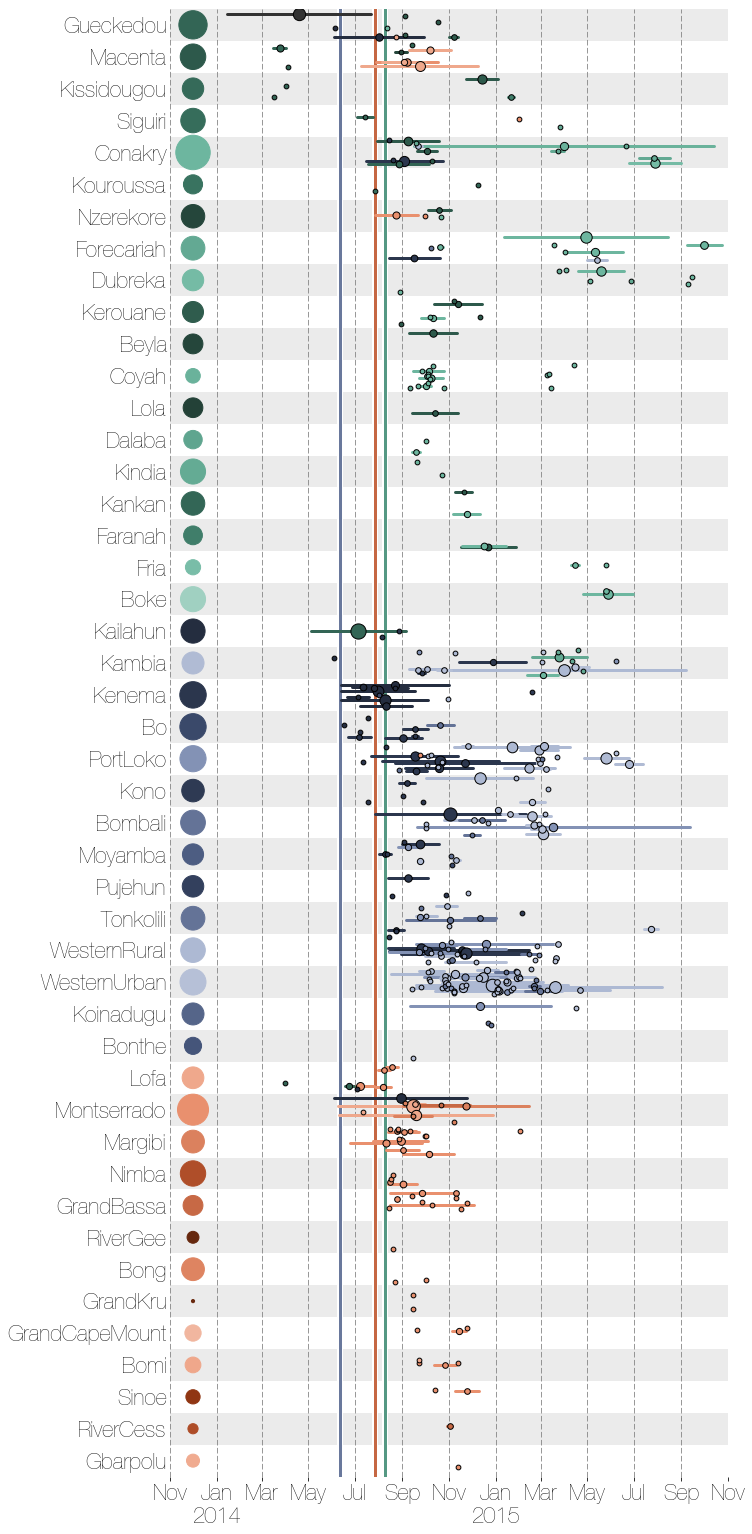

In [11]:
fig = plt.figure(figsize=(10,27),facecolor='w')
gs = gridspec.GridSpec(1, 1,wspace=0.00,hspace=0.00)
ax = plt.subplot(gs[0])

traitName='location.states'
branchWidth=2
tipSize=20

closure_dates={'SLE':'2014-06-11','GIN':'2014-08-09','LBR':'2014-07-27'}
country_order={'GIN':3,'SLE':2,'LBR':1}
earliestIntro={}

cumulative_y=0
storeDestination=''
ylabels=[]

for loc in loc_trees.keys():
    earliestIntro[loc]=min([y[1].Objects[0].absoluteTime for y in loc_trees[loc] if y[1].Objects[0].traits[traitName]==loc])

for loc in sorted(loc_trees.keys(),key=lambda x:(country_order[location_to_country[x]],-earliestIntro[x])): ## iterate over each location, sorted by country and date of first introduction

    locTree=loc_trees[loc]
    for t,tr in enumerate(locTree): ## iterate over trees
        origin,loc_tree=tr
        destination=loc_tree.Objects[0].traits[traitName]
        originTime=loc_tree.Objects[0].absoluteTime ## origin date of clade
        loc_leaves=[w for w in loc_tree.Objects if w.branchType=='leaf']
        cladeSize=float(len(loc_leaves))
        countryColour=colours[location_to_country[origin]]
        c=countryColour(normalized_coords[origin])
        lastTip=max([decimalDate(w.name.split('|')[-1]) for w in loc_leaves]) ## final tip date
        persistence=lastTip-originTime ## persistence is clade start - clade end (0 for tips)
        
        if storeDestination!=destination: ## if moving to next location - increment
            cumulative_y+=1
            ylabels.append(destination)

        radius=np.sqrt(cladeSize/np.pi)*40.0

        jitter=np.random.uniform(-0.4,0.4) ## jitter points vertically
        ax.scatter(np.mean([lastTip,originTime]),cumulative_y+jitter,s=radius,facecolor=c,edgecolor='k',zorder=10001,alpha=1.0) ## add clade size (area proportional to number of leaves in clade)
        
        ax.plot([originTime,lastTip],[cumulative_y+jitter,cumulative_y+jitter],
                lw=3,alpha=1.0,color=c,zorder=10000-cladeSize-1,solid_capstyle='round') ## add persistence line
        
        storeDestination=destination
ylabels.append(destination)

popPath=open('/Users/evogytis/Dropbox/Ebolavirus_Phylogeography/Location_GLM/sparks/sparky.csv','r')
popSizes={}
for line in popPath:
    l=line.strip('\n').split(',')
    if l[0]!='location':
        popSizes[l[0]]=float(l[-2])
popSizes['WesternArea']=popSizes['WesternUrban']+popSizes['WesternRural']
    
ax.set_yticks(range(1,len(ylabels)))
ax.set_yticklabels(ylabels)

ax.scatter([decimalDate('2013-12-01') for y in range(1,len(ylabels))],range(1,len(ylabels)),s=[10+((3.0*popSizes[loc]-3.0*min(popSizes.values()))/np.pi)**0.5 for loc in ylabels],c=[colours[location_to_country[loc]](normalized_coords[loc]) for loc in ylabels]) ## plot location pop sizes

ax.tick_params(axis='y',size=0)
ax.grid(axis='x',ls='--',color='grey',zorder=0)

[ax.axhspan(x-0.5,x+0.5,facecolor='k',edgecolor='none',alpha=0.08,zorder=0) for x in range(0,len(ylabels)+2,2)]

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

every=2
xDates=['2013-%02d-01'%x for x in range(11,13)]
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,12)]

ax.set_xticks([decimalDate(x) for x in xDates if (int(x.split('-')[1])-1)%2==0])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%2==0])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlim(decimalDate(xDates[0]),decimalDate(xDates[-1]))
ax.set_ylim(0.5,len(ylabels)-0.5)

for country in required_countries:
    ax.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=2)
    ax.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=1)

# plt.savefig(local_output+'persistences.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'persistences.pdf',dpi=300,bbox_inches='tight')
plt.show()

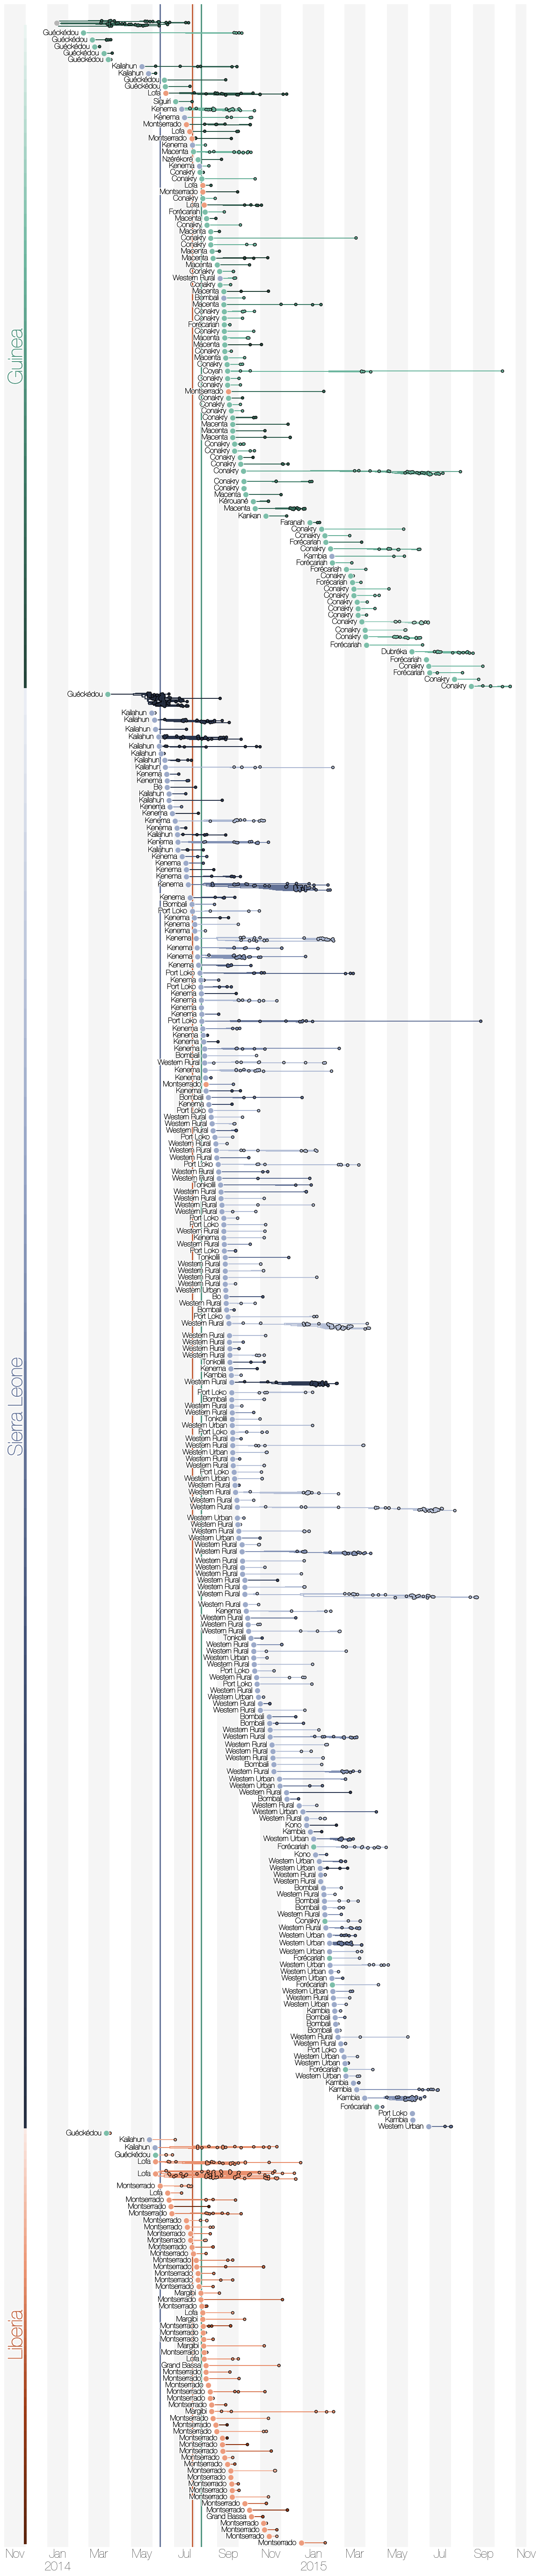

In [12]:
fig,ax = plt.subplots(figsize=(20,100),facecolor='w')

# traitName='location'
traitName='location.states'
branchWidth=2
tipSize=20

closure_dates={'SLE':'2014-06-11','GIN':'2014-08-09','LBR':'2014-07-27'} ## border closure dates
country_order={'GIN':3,'SLE':2,'LBR':1} ## order of countries

map_to_actual['WesternArea']='Western Area'

cumulative_y=0
unroll_trees=[item for sublist in loc_trees.values() for item in sublist]

sorted_trees=sorted(unroll_trees,key=lambda x:(country_order[location_to_country[x[1].Objects[0].traits[traitName]]],-x[1].root.absoluteTime))
for subtree in sorted_trees: ## iterate over countries
    origin,loc_tree=subtree

    if len([ob for ob in loc_tree.Objects if ob.branchType=='leaf'])>0: ## if there's at least one leaf in subtree
        for w in loc_tree.Objects: ## iterate over subtree branches
            location=w.traits[traitName] ## get location
            country=location_to_country[location] ## get country from location
            cmap=colours[country] ## get colour map for country
            c=cmap(normalized_coords[location]) ## get standardised colour for location

            y=w.y
            x=w.absoluteTime

            if y!=None:
                if w.parent!=None:
                    xp=w.parent.absoluteTime
                    yp=w.parent.y
                else:
                    xp=x
                    yp=y

                if isinstance(w,bt.leaf):
                    ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=c,edgecolor='none',zorder=100) ## plot tip circle
                    ax.scatter(x,y+cumulative_y,s=tipSize+30,facecolor='k',edgecolor='none',zorder=99)

                elif isinstance(w,bt.node):
                    yl=w.children[0].y
                    yr=w.children[-1].y

                    ax.plot([x,x],[yl+cumulative_y,yr+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot vertical bar

                ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot ancestral branch

        oriC=colours[location_to_country[origin]](0.3)
        if loc_tree.Objects[0].absoluteTime==None:
            oriX=loc_tree.Objects[0].absoluteTime
            oriY=loc_tree.Objects[0].y+cumulative_y
        else:
            oriX=loc_tree.Objects[0].parent.absoluteTime
            oriY=loc_tree.Objects[0].y+cumulative_y

        if origin!='reservoir':
            effects=[path_effects.Stroke(linewidth=4, foreground='white'),
             path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

            ax.text(oriX-7/365.0,oriY,'%s'%(map_to_actual[origin]),ha='right',va='center',size=16,path_effects=effects) ## uncomment to plot text at the beginning of the subtree to indicate its origin, only use with enough vertical space

        ax.scatter(oriX,oriY,150,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## circle at the base of the subtree to indicate origin

        if sorted_trees.index(subtree)==0:
            rememberCountry=country
            rememberCumulative_y=0
            
        if rememberCountry!=country or sorted_trees.index(subtree)==len(sorted_trees)-1:
            c=colours[rememberCountry](0.5)
            effects=[path_effects.Stroke(linewidth=5, foreground='w'),
             path_effects.Stroke(linewidth=1.0, foreground=c)] ## black text, white outline

            rs=np.linspace(cumulative_y,rememberCumulative_y,50)
            for r in range(len(rs)-1):
                ax.plot([decimalDate('2013-12-01')]*2,[rs[r],rs[r+1]],lw=6,color=colours[rememberCountry](r/float(len(rs)-1)),zorder=9)
            ax.text(decimalDate('2013-12-01'),(cumulative_y+rememberCumulative_y)/2.0,'%s'%(translate[rememberCountry]),size=42,rotation=90,ha='right',va='center',path_effects=effects,zorder=10)
            
            rememberCumulative_y=cumulative_y
            
        rememberCountry=country
        cumulative_y+=max([x.y for x in loc_tree.Objects])+50 ## increment y position

for country in required_countries: ## plot border closures in all axes
    ax.axvline(decimalDate(closure_dates[country]),lw=3,color=colours[country](0.5),zorder=3)
    ax.axvline(decimalDate(closure_dates[country]),lw=6,color='w',zorder=2)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

every=2
xDates=['2013-%02d-01'%x for x in range(11,13)]
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,12)]

ax.set_xlim(decimalDate(xDates[0]),decimalDate(xDates[-1]))

[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%2==0])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%2==0])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=26,size=0)
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])

ax.set_ylim(-30,cumulative_y+80)
# plt.savefig(local_output+'locTrees.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'locTrees.pdf',dpi=300,bbox_inches='tight')

plt.show()

In [13]:
# traitName='location'
traitName='location.states'
branchWidth=2
tipSize=30

ll.root.traits[traitName]='reservoir'
ll.root.y=0
ll.root.x=ll.Objects[0].absoluteTime

location_to_country['reservoir']='?'
normalized_coords['reservoir']=1.0

for k in ll.Objects:
    #print k.traits,k.parent.traits
    kloc=k.traits[traitName]
    kploc=k.parent.traits[traitName]
    if kploc!=kloc:
        if kploc=='reservoir':
            subtree=copy.deepcopy(ll.traverseWithinTrait(k,traitName))
            
local_tree=bt.tree() ## create a new tree object where the subtree will be
local_tree.Objects=subtree ## assign objects

local_tree.root.children.append(subtree[0]) ## connect objects with the root
subtree[0].parent=local_tree.root
local_tree.root.absoluteTime=subtree[0].absoluteTime-subtree[0].length

local_tree.sortBranches() ## sort branches (also draws tree)

local_tree.root.x=local_tree.Objects[0].x
local_tree.root.y=local_tree.Objects[0].y

N_times={x:0 for x in locations}
for q in local_tree.Objects:
    if isinstance(q,bt.node):
        toReplace=[]
        for ch,child in enumerate(q.children):
            childTrait=child.traits[traitName]
            parentTrait=q.traits[traitName]
            if childTrait!=parentTrait:
                toReplace.append(child)
                
        for child in toReplace:
            childTrait=child.traits[traitName]
            print q.index,parentTrait,childTrait
            N_times[childTrait]+=1
            q.children.remove(child)

            fake_leaf=bt.leaf()
            if N_times[childTrait]==1:
                if childTrait=='Conakry':
                    fake_leaf.name='%s (%s)\nGN-1 lineage'%(childTrait,location_to_country[childTrait])
                elif childTrait=='Kailahun':
                    fake_leaf.name='%s (%s), SL lineages'%(childTrait,location_to_country[childTrait])
                else:
                    fake_leaf.name='%s (%s)'%(childTrait,location_to_country[childTrait])
            else:
                fake_leaf.name='%s#%d (%s)'%(childTrait,N_times[childTrait],location_to_country[childTrait])
            fake_leaf.numName=fake_leaf.name
            fake_leaf.traits[traitName]=childTrait
            fake_leaf.index='%s%s%s'%(np.random.random(),np.random.random(),np.random.random()) ## generate random index
            fake_leaf.length=child.length
            fake_leaf.absoluteTime=q.absoluteTime+fake_leaf.length
            fake_leaf.height=q.height+fake_leaf.length
            
            fake_leaf.parent=q
            q.children.append(fake_leaf)
            q.leaves=[]
            q.numChildren=0
            local_tree.Objects.append(fake_leaf)

output_pruned=open(local_output+'Fig2_initialStages.source.tree','w')
print>>output_pruned,'#NEXUS\nBegin trees;\ntree TREE1 = [&R] %s\nEnd;'%(local_tree.toString(traits=[traitName,'posterior','%s.set'%(traitName),'%s.set.prob'%(traitName)]))
output_pruned.close()

7398980 Gueckedou Macenta
7331046 Gueckedou Siguiri
6895653 Gueckedou Conakry
6962370 Gueckedou Macenta
6895656 Gueckedou Lofa
6901014 Gueckedou Kissidougou
2 Gueckedou Kissidougou
5243 Gueckedou Kailahun


[2014.0571292856835, 2014.5463873578058, 2014.3162272448717]
[2014.0629575, 2014.5535880000002, 2014.31845]
[(2013.962699, 2014.140532), (2014.459593, 2014.610885), (2014.269624, 2014.35561)]
[('Lola', '0.00'), ('Nzerekore', '0.00'), ('Dubreka', '0.00'), ('Kindia', '0.00'), ('Kissidougou', '0.00'), ('Forecariah', '0.00'), ('Kerouane', '0.00'), ('Coyah', '0.00'), ('Conakry', '0.00'), ('Kailahun', '0.00'), ('Lofa', '0.00'), ('Macenta', '0.01'), ('Gueckedou', '0.99')]


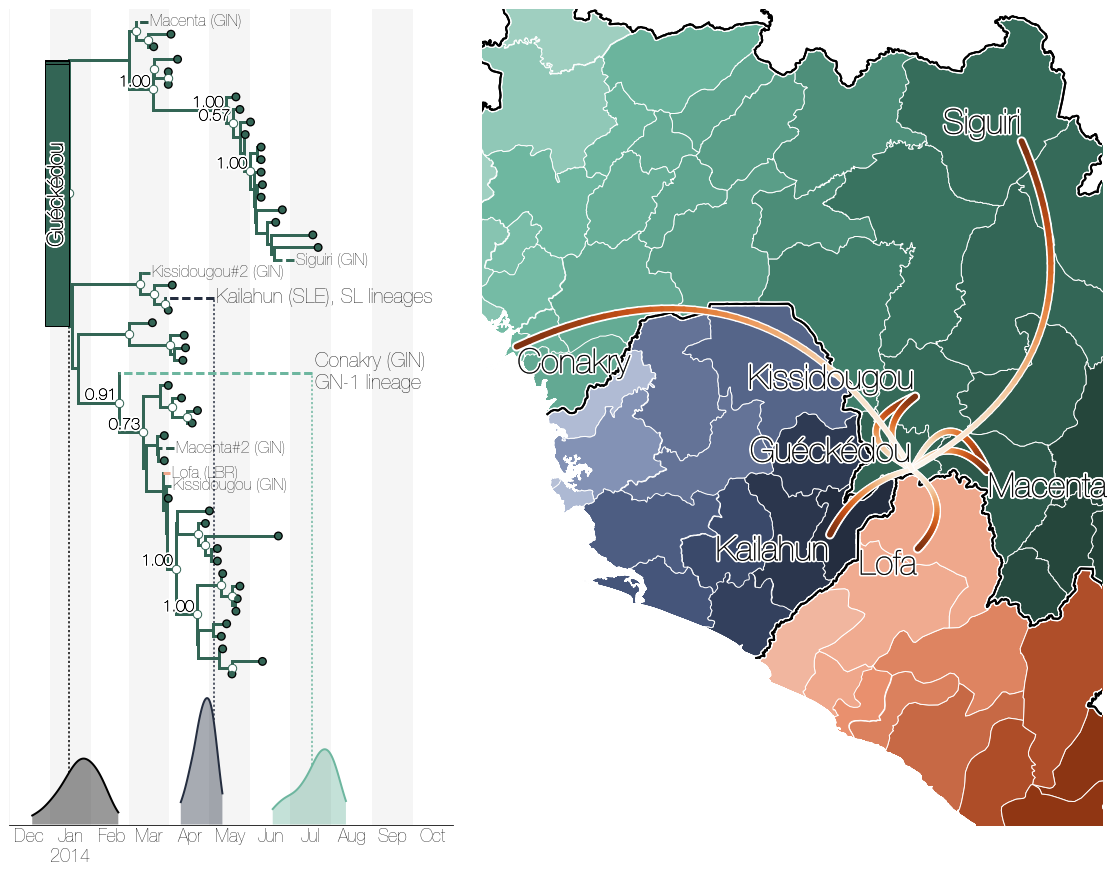

In [14]:
root_path=path_to_dropbox+'/Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run1_first_100M_used_in_revision1/Makona_1610_cds_ig.GLM.tmrcas' ## load tmrca distributions

burnin=10000000
for line in open(root_path,'r'):
    l=line.strip('\n').split('\t')
    if l[0]=='state':
        header=l
        param_idx={x:i for i,x in enumerate(header)}
        params=header[1:]
        rootHeights={x:[] for x in params}
    elif float(l[0])>=burnin:
        for param in params:
            rootHeights[param].append(float(l[param_idx[param]]))

print [np.mean(x) for x in rootHeights.values()]
print [np.median(x) for x in rootHeights.values()]
print [hpd(x,0.95) for x in rootHeights.values()]

fig = plt.figure(figsize=(20, 15)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5],wspace=0.01) 

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# fig,ax = plt.subplots(figsize=(10,15),facecolor='w')
tipSize=40
branchWidth=3

local_tree.traverse_tree()
local_tree.sortBranches(descending=True)
effects=[path_effects.Stroke(linewidth=4, foreground='w'),path_effects.Stroke(linewidth=0.5, foreground='k')]

offsetTree=10
for w in local_tree.Objects:
    location=w.traits[traitName]
    country=location_to_country[location]
    cmap=colours[country]
    c=cmap(normalized_coords[location])
    y=w.y+offsetTree
    x=w.absoluteTime

    if y!=None:
        if w.parent!=None:
            xp=w.parent.absoluteTime
            yp=w.parent.y
        else:
            xp=x
            yp=y

        if isinstance(w,bt.leaf):
            ls='-'
            if w.traits[traitName]!='Gueckedou':
                s=16
                if w.name[-1]!=')':
                    s=20
#                     ax.text(x+0.005,y,'%s'%(w.name),size=s,ha='left',va='center',path_effects=effects)
                    ax.text(x+0.005,y,'%s'%(w.name),size=s,ha='left',va='center')
                else:
                    ax.text(x+0.005,y,'%s'%(w.name),size=s,ha='left',va='center')
                ls='--'
            else:
                ax.scatter(x,y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
                ax.scatter(x,y,s=tipSize*2,facecolor='k',edgecolor='none',zorder=99)
            ax.plot([x,xp],[y,y],color=c,lw=branchWidth,ls=ls,zorder=98)
            
        elif isinstance(w,bt.node):
            yl=w.children[0].y+offsetTree
            yr=w.children[-1].y+offsetTree
            
            if w.traits['posterior']>=0.5:
                ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
                if len(w.leaves)>=5 and w.parent.index!='Root':
                    vas=['bottom','top']
                    va=vas[w.parent.children.index(w)-1]
                    ax.text(x-2/365.0,y+((w.parent.children.index(w)-1)*0.2),'%.2f'%(w.traits['posterior']),
                            va=va,ha='right',size=16,path_effects=effects,zorder=101)
#                     ax.text(x-2/365.0,y+((w.parent.children.index(w)-1)*0.2),'%.2f'%(w.traits['posterior']),
#                             va=va,ha='right',size=16,zorder=101)
                    
            
            if w.parent==local_tree.root:
#                 location_states=w.traits['%s.states.set'%(traitName)]
#                 location_probs=w.traits['%s.states.set.prob'%(traitName)]
                location_states=w.traits['%s.set'%(traitName)]
                location_probs=w.traits['%s.set.prob'%(traitName)]
                join_probs={a:b for a,b in zip(location_states,location_probs)}
                sort_locations=sorted(join_probs.keys(),key=lambda a:join_probs[a])
                print [(a,'%.2f'%join_probs[a]) for a in sort_locations]
                width=0.05
                heightRange=yr-yl
                start=yl
                for loc in sort_locations:
                    height=heightRange*join_probs[loc]
                    #print loc,'%.2f'%(join_probs[loc])
                    country=location_to_country[loc]
                    fc=colours[country](normalized_coords[loc])
                    
                    if join_probs[loc]>=0.2:
                        ax.text(x-width*0.5,np.mean([start,start+height]),'%s'%(map_to_actual[loc]),rotation=90,zorder=101,
                                va='center',ha='center',path_effects=effects)
#                         ax.text(x-width*0.5,np.mean([start,start+height]),'%s'%(map_to_actual[loc]),rotation=90,zorder=101,
#                                 va='center',ha='center')
                    ax.add_patch(plt.Rectangle((x-width,start),width,height,facecolor=fc,edgecolor='k',lw=1,zorder=100))
                    start+=height
                
            ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98)
            ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98)

for intro in rootHeights.keys():
    hpdLo,hpdHi=hpd(rootHeights[intro],0.95)

    x_grid=np.linspace(hpdLo,hpdHi,100)
    kde=gaussian_kde(rootHeights[intro],0.3)
    y_grid=kde.evaluate(x_grid)

    root_y=[(y*0.6)-1 for y in y_grid]
    
    if intro=='Root':
        c='k'
        #intro='reservoir'
    else:
        c=colours[location_to_country[intro]](normalized_coords[intro])

    if intro!='Root':
        topX,topY=[(k.absoluteTime,k.y+offsetTree) for k in local_tree.Objects if k.traits[traitName]==intro][-1]
    else:
        topX,topY=local_tree.Objects[0].absoluteTime,local_tree.Objects[0].children[0].y+offsetTree
        
    bottomX=topX
    bottomY=(kde.evaluate(bottomX)*0.6)-1
        
    ax.plot([bottomX,topX],[bottomY,topY],ls=':',color=c)
    
    ax.fill_between(x_grid,root_y,y2=-1,facecolor=c,edgecolor='none',alpha=0.4)
    ax.plot(x_grid,root_y,lw=2,color=c,ls='-')
          

every=1
xDates=['2013-%02d-01'%x for x in range(1,13)]
xDates+=['2014-%02d-01'%x for x in range(1,12)]
# xDates+=['2015-%02d-01'%x for x in range(1,12)]


[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.tick_params(axis='y',size=0)
ax.tick_params(axis='x',labelsize=18,size=0)
ax.set_yticklabels([])

ax.set_xlim(decimalDate('2013-12-01'),decimalDate(xDates[-1]))
ax.set_ylim(-1,(len(local_tree.Objects)+1)/2.0+offsetTree+1)

for loc in locations:
    if location_to_country[loc] in required_countries:
        countryColour=colours[location_to_country[loc]]
        c=countryColour(normalized_coords[loc])
        ax2.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor='w',lw=1,zorder=1))


normalize_height=create_normalization([x.parent.absoluteTime for x in local_tree.Objects if len(x.parent.traits)>0 and x.traits[traitName]!=x.parent.traits[traitName]],0.0,1.0)

destinationXs=[]
destinationYs=[]
destinations=['Gueckedou']
for w in local_tree.Objects:
    if len(w.parent.traits)>0:
        locA=w.traits[traitName]
        locB=w.parent.traits[traitName]
        if locA!=locB:
            destinations.append(locA)
            country=location_to_country[location]
            cmap=colours[country]
            c=cmap(normalized_coords[location])
            y=w.y
            x=w.absoluteTime

            if y!=None:
                if w.parent!=None:
                    xp=w.parent.absoluteTime
                    yp=w.parent.y
                else:
                    xp=x
                    yp=y

            end=w.height
            start=w.parent.height

            oriX,oriY=popCentres[locB]
            desX,desY=popCentres[locA]

            destinationXs.append(desX)
            destinationYs.append(desY)
            
            ## normalize time of lineage
            normalized_height=normalize_height(w.absoluteTime)
            normalized_parent_height=normalize_height(w.parent.absoluteTime)
            #print normalized_height,normalized_parent_height
            ## define Bezier curve
            distance=math.sqrt(math.pow(oriX-desX,2)+math.pow(oriY-desY,2))

            ## adjust_d is the function that determines where the Bezier line control point will be
#             adjust_d=distance-(distance**0.5)*normalized_height
            adjust_d=0.1-2*normalized_height+1/float(distance)**0.1-0.1

            ## control point coordinate set perpendicular to midway between point A and B at a distance adjust_d
            n=Bezier_control((oriX,oriY),(desX,desY),adjust_d)

            ## get Bezier line coordinates
            curve=Bezier([(oriX,oriY),n,(desX,desY)],0.0,1.0,num=40)

            midpoint=np.mean([normalized_parent_height,normalized_height])

            ## iterate through Bezier curve coordinates, alter colour according to height
            for i in range(len(curve)-1):
                x1,y1=curve[i]
                x2,y2=curve[i+1]
                frac=(i/float(len(curve)))

                ax2.plot([x1,x2],[y1,y2],lw=4+2*frac,color=desaturate(mpl.cm.Oranges(frac),0.8),
                         zorder=int(normalized_height*10000),solid_capstyle='round')
                ax2.plot([x1,x2],[y1,y2],lw=6+4*frac,color='w',zorder=int(normalized_height*10000)-1,solid_capstyle='round')
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.tick_params(size=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

## identify the longest axis
frameLength=max([max(destinationXs)-min(destinationXs),max(destinationYs)-min(destinationYs)])

for loc in destinations:
    ## define available text alignments and corrections for text positions
    vas=['bottom','top']
    has=['left','right']
    corrections=[0.01,-0.01]

    ## set default text alignment (right, top)
    h=1
    v=1
    ## check if custom text positions are available
    if textCorrection.has_key(loc):
        if loc=='Kissidougou' or loc=='Siguiri' or loc=='Gueckedou':
            h=1
            v=0
        elif loc=='Conakry':
            h=0
            v=1
        elif loc=='Macenta':
            h=0
            v=1

    effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]
    
    lon,lat=popCentres[loc]
    ## plot district names at population centres, with corrections so as not to obscure it
    ax2.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=34,
             va=vas[v],ha=has[h],alpha=1.0,path_effects=effects,zorder=100000)
#     ax2.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=34,
#              va=vas[v],ha=has[h],alpha=1.0,zorder=100000)


ax2.set_xlim(min(destinationXs)-0.3,max(destinationXs)+0.7)
ax2.set_ylim(min(destinationYs)-2.4,max(destinationYs)+1.15)
ax2.set_aspect(1)

for l,local_border in enumerate(global_border):
    ax2.plot(column(local_border,0),column(local_border,1),lw=2,color='k',zorder=97,label='%d_border'%(l))
    ax2.plot(column(local_border,0),column(local_border,1),lw=5,color='w',zorder=96)

# plt.savefig(local_output+'InitialStages.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'InitialStages.pdf',dpi=300,bbox_inches='tight')

plt.show()

In [15]:
output_countrees=open(local_output+'Fig3_trees.source.tree','w')
print>>output_countrees,'#NEXUS\nBegin trees;\n'

for country in sorted(country_trees.keys(),key=lambda x:country_order[x]): ## iterate over countries
    for t,tr in enumerate(sorted(country_trees[country],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): 
        origin,loc_tree=tr
        tree_string=loc_tree.toString(traits=['posterior',traitName,'%s.set'%(traitName),'%s.set.prob'%(traitName)])
        if len(loc_tree.Objects)>1:
            print>>output_countrees,'tree %s_%s = [&R] %s'%(location_to_country[origin],t+1,tree_string)
        else:
            print 'singleton tree:',tree_string

print>>output_countrees,'End;'
output_countrees.close()

singleton tree: 'EBOV|EM_080213|KR817240|LBR|?|2014-07-03'[&location.states="Lofa",location.states.set={"Nimba","RiverCess","Margibi","GrandCapeMount","Sinoe","Bong","Montserrado","Lofa","GrandBassa","Maryland","Gbarpolu","GrandKru","GrandGedeh","RiverGee","Bomi"},location.states.set.prob={0.012110438309,0.0022776512416,0.013388145103,0.0170546080773,0.00255541358813,0.0126104105327,0.0892728181768,0.636909060608,0.0168323982001,0.00122215432476,0.180045553025,0.00194433642575,0.00211099383368,0.0014999166713,0.0101661018832}]:0.100920;
singleton tree: 'EBOV|EM_079450|KR817194|LBR|?|2014-04-01'[&location.states="Lofa",location.states.set={"Nimba","Bong","Montserrado","Lofa","RiverCess","GrandBassa","Margibi","GrandCapeMount","GrandKru","Gbarpolu","Maryland","Sinoe","GrandGedeh","RiverGee","Bomi"},location.states.set.prob={0.0107216265763,0.00966612965946,0.0701627687351,0.863063163158,0.00172212654853,0.0111104938615,0.00822176545747,0.00377756791289,0.00222209877229,0.00572190433865,0

In [16]:
branchWidth=2
tipSize=30

traitName='location.states'
# traitName='location'
ll.root.traits[traitName]='reservoir' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch
ll.root.y=0
ll.root.x=ll.Objects[0].absoluteTime

dummy=copy.deepcopy(ll)

location_to_country['reservoir']='?'
normalized_coords['reservoir']=1.0

loc_trees={}

components=[]

for l in sorted(dummy.Objects,key=lambda x:x.height): ## iterate over branches
    k=l
    kp=l.parent
    
    kloc=k.traits[traitName]
    if k.parent.traits.has_key(traitName): ## get current branch's country and its parent's country
        kploc=kp.traits[traitName]
        kpc=location_to_country[kploc]
    else:
        kploc='reservoir'
        kpc='reservoir'

    kc=location_to_country[kloc]
    if kc!=kpc:
#     if kloc!=kploc: ## if locations don't match
        proceed=False ## assume we still can't proceed forward
        
        if isinstance(k,bt.leaf): ## if dealing with a leaf - proceed
            N_children=1
            proceed=True
        else:
            N_children=len(k.leaves)
#             if [ch.traits[traitName] for ch in k.children].count(kloc)>0: ## if locations don't match
            if [location_to_country[ch.traits[traitName]] for ch in k.children].count(kc)>0: ## if locations don't match
                proceed=True
        
        subtree=copy.deepcopy(dummy.traverseWithinTrait(k,traitName,location_to_country))
        subtree_leaves=[x.name for x in subtree if isinstance(x,bt.leaf)]
        
        if len(subtree_leaves)>0 and proceed==True: ## if at least one valid tip and no hanging nodes
            print '%s (%s) to %s (%s) jump (ancestor %d, %d leaves in full tree, now has %d)'%(kpc,kploc,kc,kloc,k.index,N_children,len(subtree_leaves))
            
            orderedTips=sorted([w for w in subtree if w.branchType=='leaf'],key=lambda x:x.absoluteTime)
            lastTip=orderedTips[-1] ## identify most recent tip
            firstTip=orderedTips[0]
            cur_node=firstTip

            while cur_node: ## while not at root
                if cur_node==firstTip: ## if at the beginning of descent
                    if k.branchType=='node': ## and node
                        cladeOb=bt.clade(firstTip.numName) ## create a clade object
                        cladeOb.length=firstTip.length
                        cladeOb.index=firstTip.index
                        cladeOb.absoluteTime=firstTip.parent.absoluteTime
                        cladeOb.lastAbsoluteTime=lastTip.absoluteTime
                        cladeOb.traits=k.traits
                        cladeOb.width=np.log(len(subtree_leaves)+2)
                        cladeOb.leaves=subtree_leaves
                        cladeOb.parent=firstTip.parent
                        firstTip.parent.children.append(cladeOb) ## replace tip with clade object
                        firstTip.parent.children.remove(firstTip)
                        cur_node=cladeOb
                    
                components.append(cur_node) ## add descent line to components
                cur_node=cur_node.parent ## continue descent
            
            components=list(set(components)) ## only keep unique branches

print 'Done!'

? (reservoir) to GIN (Gueckedou) jump (ancestor 0, 1610 leaves in full tree, now has 118)
GIN (Gueckedou) to LBR (Lofa) jump (ancestor 6895657, 1 leaves in full tree, now has 1)
GIN (Gueckedou) to SLE (Kailahun) jump (ancestor 5244, 1485 leaves in full tree, now has 1010)
SLE (Kailahun) to GIN (Gueckedou) jump (ancestor 6830844, 10 leaves in full tree, now has 7)
SLE (Kailahun) to LBR (Montserrado) jump (ancestor 5118496, 327 leaves in full tree, now has 205)
SLE (Kailahun) to GIN (Gueckedou) jump (ancestor 6798737, 1 leaves in full tree, now has 1)
GIN (Gueckedou) to LBR (Lofa) jump (ancestor 6830846, 3 leaves in full tree, now has 3)
SLE (Kailahun) to LBR (Lofa) jump (ancestor 6821709, 1 leaves in full tree, now has 1)
LBR (Lofa) to GIN (Macenta) jump (ancestor 6046989, 26 leaves in full tree, now has 26)
SLE (Kenema) to GIN (Conakry) jump (ancestor 1610183, 123 leaves in full tree, now has 107)
LBR (Montserrado) to GIN (Nzerekore) jump (ancestor 6444072, 7 leaves in full tree, now h

763


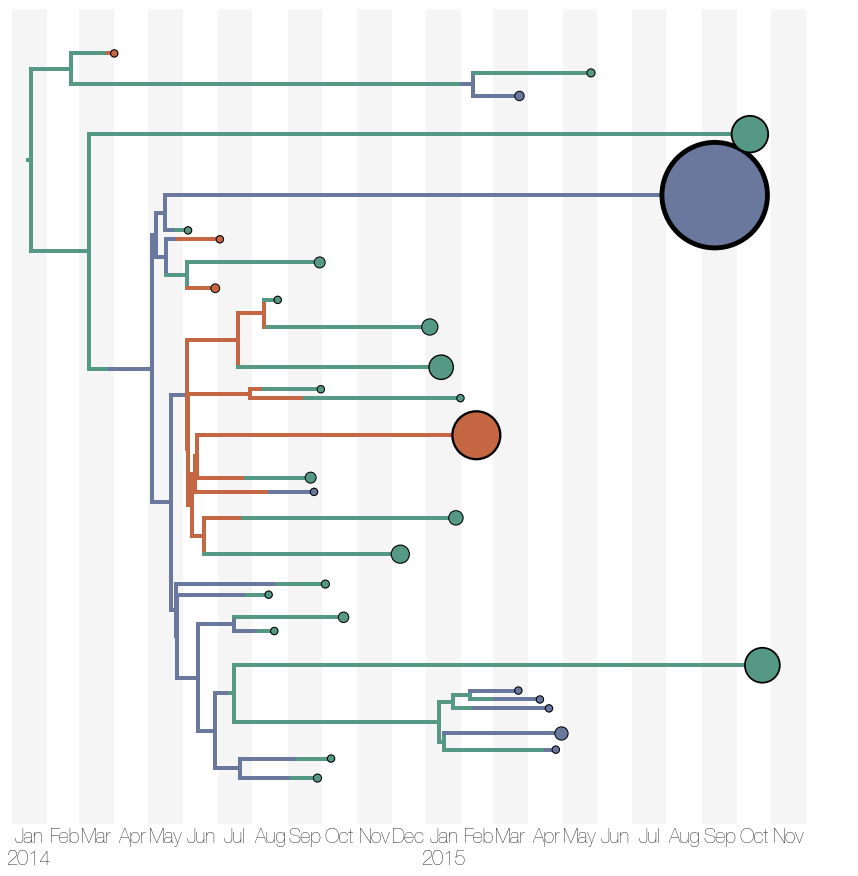

In [17]:
fig,ax = plt.subplots(figsize=(15,15),facecolor='w')

traitName='location.states'

tipSize=10 ## tip circle radius
branchWidth=4 ## line width for branches

posteriorCutoff=0.0 ## posterior cutoff if collapsing tree

# plot_tree=bt.tree()
c=list(set(components))
print len(c)
d=copy.deepcopy(dummy)
for k in sorted(d.Objects,key=lambda x:-x.height):
    if k.index not in [w.index for w in c]:
        d.Objects.remove(k) ## remove branches not in components
        k.parent.children.remove(k)
        
    elif k.branchType=='leaf' and k.index in [w.index for w in c if isinstance(w,bt.clade)]:
        d.Objects.remove(k)
        r=[w for w in c if isinstance(w,bt.clade) and w.index==k.index][0] ## replace leaves with clade objects
        r.parent=k.parent
        k.parent.children.append(r)
        k.parent.children.remove(k)
        d.Objects.append(r)
                    

d.sortBranches()
plot_tree=d

for k in plot_tree.Objects: ## iterate over branches in the tree
    location=k.traits[traitName] ## get inferred location of branch
    country=location_to_country[location] ## find country of location
    cmap=colours[country] ## fetch colour map for country
#     c=cmap(normalized_coords[location]) ## get colour of location
    c=cmap(0.5) ## get colour of location
    y=k.y ## get y coordinates
    yp=k.parent.y ## get parent's y coordinate
    
    x=k.absoluteTime ## x coordinate is absolute time
    xp=k.parent.absoluteTime ## get parent's absolute time
    
    convert=lambda x:np.sqrt(x)/np.pi
    
    if k.branchType=='leaf': ## if tip...
        if isinstance(k,bt.leaf): ## if really tip
            ax.scatter(x,y,s=30+tipSize,facecolor=c,edgecolor='none',zorder=100) ## put a circle at each tip
            ax.scatter(x,y,s=30+tipSize*1.2+30,facecolor='k',edgecolor='none',zorder=99)
        else: ## if clade
#             clade=plt.Polygon(([x-0.05*k.length,y-0.0001*len(plot_tree.Objects)],[x-0.05*k.length,y+0.0001*len(plot_tree.Objects)],[k.lastAbsoluteTime,y+k.width/2.0],[k.lastAbsoluteTime,y-k.width/2.0]),facecolor=c,edgecolor='none',zorder=12)
#             ax.add_patch(clade) ## add triangle
            #ax.text(k.lastAbsoluteTime+0.01,y,len(k.leaves),va='center',ha='left')
            ax.plot([k.lastAbsoluteTime,xp],[y,y],color=c,lw=branchWidth,zorder=98)
            ax.scatter(k.lastAbsoluteTime,y,s=30+len(k.leaves)*tipSize,facecolor=c,edgecolor='none',zorder=100)
            ax.scatter(k.lastAbsoluteTime,y,s=30+len(k.leaves)*tipSize*1.2+30,facecolor='k',edgecolor='none',zorder=99)
            
    elif isinstance(k,bt.node): ## if node...
        yl=k.children[0].y ## get y coordinates of first and last child
        yr=k.children[-1].y
        
        if xp==0.0:
            xp=x

        ls='-'
        if k.traits['posterior']<posteriorCutoff: ## change to dotted line if posterior probability too low
            ls='--'
        ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,ls=ls,zorder=98) ## plot vertical bar connecting node to both its offspring
        
    ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98) ## plot horizontal branch to parent
    
ax.xaxis.tick_bottom() ## tick bottom
ax.yaxis.tick_left() ## tick left

xDates=['2013-%02d-01'%x for x in range(11,13)] ## create a timeline centered on each month
xDates+=['2014-%02d-01'%x for x in range(1,13)]
xDates+=['2015-%02d-01'%x for x in range(1,12)]

[ax.axvspan(decimalDate(xDates[x]),decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)] ## grey vertical bar every second month
ax.set_xticks([decimalDate(x)+1/24.0 for x in xDates]) ## x ticks in the middle of each month
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates]) ## labels in mmm format unless January: then do YYYY-mmm

ax.spines['top'].set_visible(False) ## make axes invisible
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=20,size=0) ## no axis labels visible except for timeline
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])

ax.set_xlim(left=decimalDate('2014-01-01')) ## bounds on axis limits
ax.set_ylim(-4,plot_tree.ySpan+5)

plt.show()